# DEEP NEURAL NETWORKS - ASSIGNMENT 2: CNN FOR IMAGE CLASSIFICATION

## Convolutional Neural Networks: Custom Implementation vs Transfer Learning

STUDENT INFORMATION (REQUIRED - DO NOT DELETE)

BITS ID: 2025AA05360

Name: PAUL J PALATHINGAL

Email: 2025aa05360@wilp.bits-pilani.ac.in

Date: 02-02-2026

In [32]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os


#!pip install kagglehub
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("salader/dogsvscats")

#print("Path to dataset files:", path)

In [33]:
# Deep learning frameworks (choose Keras or PyTorch)
# For image processing
from PIL import Image
######### import cv2

### 1.1 Dataset Selection and Loading

Load dataset

In [34]:
# REQUIRED: Fill in these metadata fields
dataset_name = "Microsoft Cats vs Dogs"
dataset_source = "https://www.kaggle.com/datasets/salader/dogsvscats"

# Path to the dataset locally downloaded
dataset_path = r"C:\learning_misc\catsvsdogs"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

train_cat_path = os.path.join(train_path, "cats")
train_dog_path = os.path.join(train_path, "dogs")
test_cat_path = os.path.join(test_path, "cats")
test_dog_path = os.path.join(test_path, "dogs")

# Count image files
train_cats_count = len([f for f in os.listdir(train_cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
train_dogs_count = len([f for f in os.listdir(train_dog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_cats_count = len([f for f in os.listdir(test_cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
test_dogs_count = len([f for f in os.listdir(test_dog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Calculate totals
train_total = train_cats_count + train_dogs_count
test_total = test_cats_count + test_dogs_count
total_samples = train_total + test_total

n_samples = total_samples   # Total number of images
n_classes = 2               # Number of classes
samples_per_class = f"min: {min(train_cats_count+test_cats_count, train_dogs_count+test_dogs_count)}, max: {max(train_cats_count+test_cats_count, train_dogs_count+test_dogs_count)}, avg: {(train_cats_count + test_cats_count + train_dogs_count + test_dogs_count) // 2}"

sample_img_path = os.path.join(train_cat_path, os.listdir(train_cat_path)[0])
sample_img = Image.open(sample_img_path)

# PIL returns (width, height), but we need [height, width, channels]
original_width, original_height = sample_img.size
channels = 3 if sample_img.mode == 'RGB' else 1

image_shape =  [original_height, original_width, channels]         # [height, width, channels] , there are differnt image sizes in the dataset
problem_type = "classification"





In [35]:
# Primary metric selection
primary_metric = "Accuracy"
metric_justification = "We have balanced dataset with two classes with equal samples. Accuracy is suitable metric to evaluate overall performance in this dataset."


In [36]:
print("DATASET INFORMATION")
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes}")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")

DATASET INFORMATION
Dataset: Microsoft Cats vs Dogs
Source: https://www.kaggle.com/datasets/salader/dogsvscats
Total Samples: 25000
Number of Classes: 2
Samples per Class: min: 12500, max: 12500, avg: 12500
Image Shape: [374, 500, 3]
Primary Metric: Accuracy
Metric Justification: We have balanced dataset with two classes with equal samples. Accuracy is suitable metric to evaluate overall performance in this dataset.


### 1.2 Data Exploration and Visualization

- TODO: Show sample images from each class
- TODO: Plot class distribution
- TODO: Display image statistics

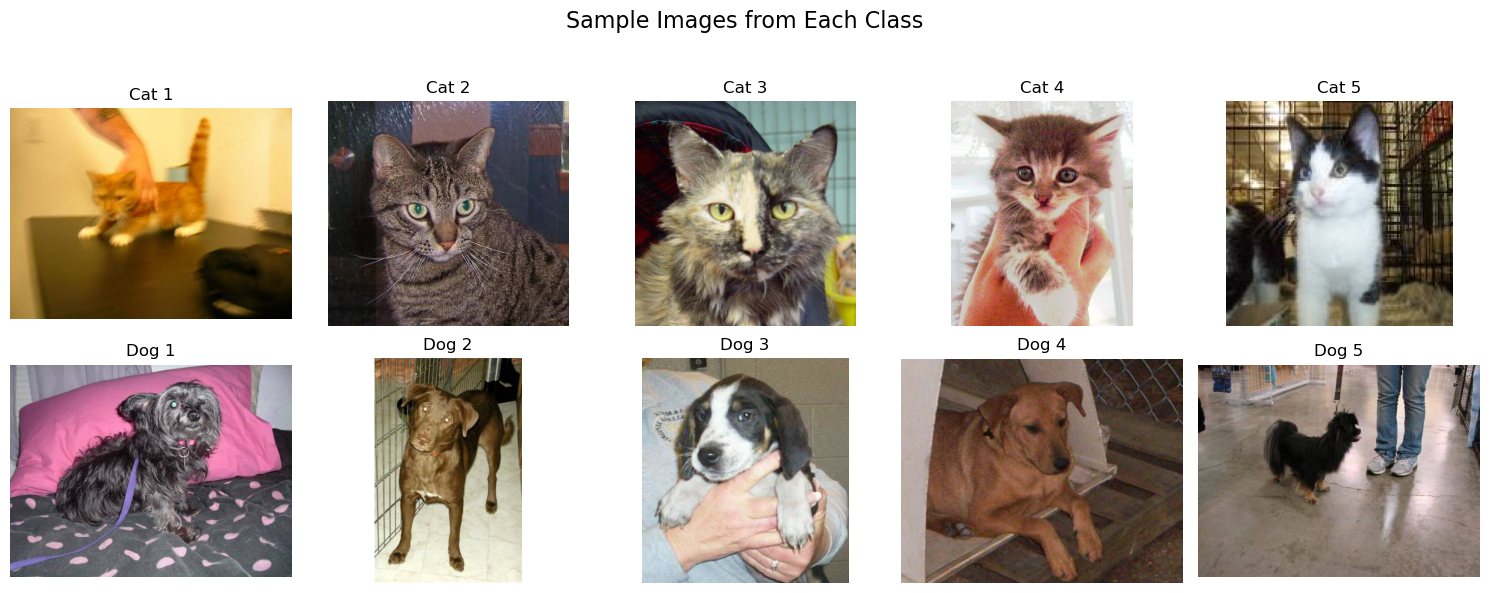

In [37]:
# Show sample images from each class
num_samples = 5                                             # Number of images to display per class
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))   

cat_images = os.listdir(train_cat_path)[:num_samples]       
dog_images = os.listdir(train_dog_path)[:num_samples]       

for i, img_name in enumerate(cat_images):                   # getting first 5 images from cat class
    img_path = os.path.join(train_cat_path, img_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Cat {i+1}")
    axes[0, i].axis('off')

for i, img_name in enumerate(dog_images):                   # getting first 5 images from dog class
    img_path = os.path.join(train_dog_path, img_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Dog {i+1}")
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Cats', fontsize=14)
axes[1, 0].set_ylabel('Dogs', fontsize=14)
plt.suptitle('Sample Images from Each Class', fontsize=16)  # ploting the sample figures
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

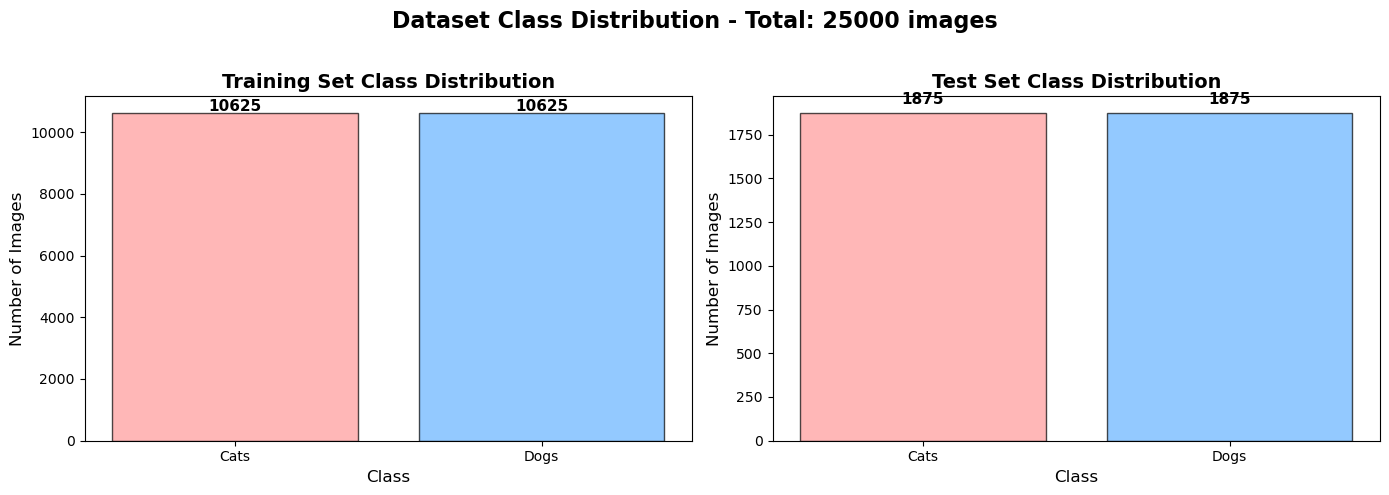


Class Distribution Summary:
Class      Train      Test       Total     
----------------------------------------
Cats       10625      1875       12500     
Dogs       10625      1875       12500     
----------------------------------------
Total      21250      3750       25000     


In [38]:
# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = [train_cats_count, train_dogs_count]
train_labels = ['Cats', 'Dogs']
colors = ['#ff9999', '#66b3ff']

axes[0].bar(train_labels, train_counts, color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Training Set Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
for i, count in enumerate(train_counts):
    axes[0].text(i, count + 50, str(count), ha='center', fontsize=11, fontweight='bold')

# Test set distribution
test_counts = [test_cats_count, test_dogs_count]
test_labels = ['Cats', 'Dogs']

axes[1].bar(test_labels, test_counts, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
for i, count in enumerate(test_counts):
    axes[1].text(i, count + 50, str(count), ha='center', fontsize=11, fontweight='bold')

plt.suptitle(f'Dataset Class Distribution - Total: {total_samples} images', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print distribution summary
print("\nClass Distribution Summary:")
print(f"{'Class':<10} {'Train':<10} {'Test':<10} {'Total':<10}")
print("-" * 40)
print(f"{'Cats':<10} {train_cats_count:<10} {test_cats_count:<10} {train_cats_count + test_cats_count:<10}")
print(f"{'Dogs':<10} {train_dogs_count:<10} {test_dogs_count:<10} {train_dogs_count + test_dogs_count:<10}")
print("-" * 40)
print(f"{'Total':<10} {train_total:<10} {test_total:<10} {total_samples:<10}")

### 1.3 Data Preprocessing
- TODO: Resize images to consistent size
- TODO: Normalize pixel values
- TODO: Split into train/test (90/10 or 85/15)

In [39]:
# Train Test Data Split split
train_test_ratio = "85/15"      # 85% training, 15% testing , as per original dataset split
train_samples = train_total     # Number of training samples
test_samples = test_total       # Number of test samples

In [40]:
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples}")
print(f"Test Samples: {test_samples}")


Train/Test Split: 85/15
Training Samples: 21250
Test Samples: 3750


In [41]:
# Import TensorFlow/Keras for data preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image preprocessing parameters
IMG_HEIGHT = 128  # Standard size for many pre-trained models
IMG_WIDTH = 128
BATCH_SIZE = 32

print(f"Image preprocessing configuration:")
print(f"Target size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Normalization: Pixel values will be scaled to [0, 1]")

Image preprocessing configuration:
Target size: 128x128
Batch size: 32
Normalization: Pixel values will be scaled to [0, 1]


In [42]:
# Create ImageDataGenerator for training data with normalization
# Rescale pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(
    rescale=1./255           # Normalize pixel values to [0, 1]
)

# Create ImageDataGenerator for test data with only normalization
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data augmentation and normalization setup:")
print("- Training images: Normalized to [0, 1]")
print("- Test images: Normalized to [0, 1]")
print("- Using pre-split train and test folders (no validation split from training)")

Data augmentation and normalization setup:
- Training images: Normalized to [0, 1]
- Test images: Normalized to [0, 1]
- Using pre-split train and test folders (no validation split from training)


In [43]:
# Create data generators with resizing and normalization
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',              # For multi-class classification
    shuffle=True,
    seed=42
)

# Test data generator (already split in separate folder)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to 128x128
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nData generators created successfully:")
print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")
print(f"Number of batches - Train: {len(train_generator)}, Test: {len(test_generator)}")

Found 21250 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.

Data generators created successfully:
Training samples: 21250
Test samples: 3750

Class indices: {'cats': 0, 'dogs': 1}
Number of batches - Train: 665, Test: 118



Preprocessing verification:
Batch shape: (32, 128, 128, 3)
Labels shape: (32, 2)
Pixel value range: [0.0000, 1.0000]
Mean pixel value: 0.4587
Std pixel value: 0.2627


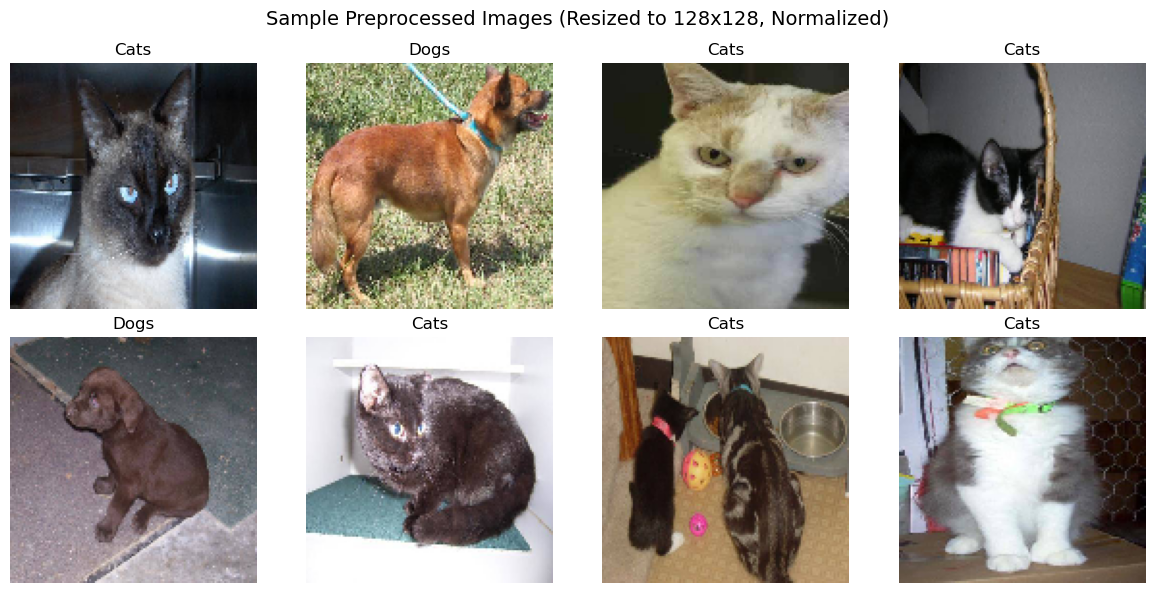

In [44]:
# Verify preprocessing by displaying a batch of processed images
sample_batch, sample_labels = next(train_generator)

print(f"\nPreprocessing verification:")
print(f"Batch shape: {sample_batch.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Pixel value range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")
print(f"Mean pixel value: {sample_batch.mean():.4f}")
print(f"Std pixel value: {sample_batch.std():.4f}")

# Display sample preprocessed images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i])
    class_idx = np.argmax(sample_labels[i])
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"{class_name.capitalize()}")
    axes[i].axis('off')

plt.suptitle(f'Sample Preprocessed Images (Resized to {IMG_HEIGHT}x{IMG_WIDTH}, Normalized)', fontsize=14)
plt.tight_layout()
plt.show()

# Reset the generator after sampling
train_generator.reset()

### 2.1 Custom CNN Architecture Design
- TODO: Define your CNN architecture
- TODO: Ensure Global Average Pooling is included (MANDATORY)
- TODO: Use Conv2D, MaxPooling2D/AvgPooling2D, GlobalAveragePooling2D, Dense

In [45]:
def build_custom_cnn(input_shape, n_classes):
    """
    Build custom CNN architecture
    
    Args:
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled CNN model
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
    
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # Global Average Pooling (MANDATORY - replaces Flatten + Dense)
        GlobalAveragePooling2D(),
        
        # Dropout for regularization
        Dropout(0.5),
        
        # Output Layer with Softmax
        Dense(n_classes, activation='softmax')
    ])
    
    return model

In [46]:
# Create model instance
custom_cnn = build_custom_cnn(image_shape, n_classes)

# Display model architecture
print("\n Custom CNN Architecture:")
custom_cnn.summary()

# Count parameters
total_params = custom_cnn.count_params()
print(f"\nTotal parameters: {total_params:,}")


 Custom CNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,850 (1.49 MB)

 Trainable params: 389,890 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)


Total parameters: 390,850


In [47]:
# Compile model
from tensorflow.keras.optimizers import Adam

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: categorical_crossentropy")
print(f"Metrics: accuracy")

Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss function: categorical_crossentropy
Metrics: accuracy


### 2.2 Train Custom CNN

In [48]:
print("\nCUSTOM CNN TRAINING")
# Track training time
custom_cnn_start_time = time.time()


CUSTOM CNN TRAINING


In [49]:
# Train the model
EPOCHS = 20

print(f"Training for {EPOCHS} epochs...\n")

history = custom_cnn.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=1
)

print("\nTraining completed!")

Training for 20 epochs...



c:\Users\jisap\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.6636 - loss: 0.6292
Epoch 2/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 1509s 2s/step - accuracy: 0.7615 - loss: 0.4928
Epoch 3/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 19758s 30s/step - accuracy: 0.8315 - loss: 0.3798
Epoch 4/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 513s 771ms/step - accuracy: 0.8728 - loss: 0.2997
Epoch 5/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 529s 795ms/step - accuracy: 0.8973 - loss: 0.2497
Epoch 6/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 539s 811ms/step - accuracy: 0.9127 - loss: 0.2116
Epoch 7/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 550s 828ms/step - accuracy: 0.9247 - loss: 0.1892
Epoch 8/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 522s 786ms/step - accuracy: 0.9357 - loss: 0.1620
Epoch 9/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 502s 755ms/step - accuracy: 0.9427 - loss: 0.1451
Epoch 10/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 587s 883ms/step - accuracy: 0.9461 - loss: 0.1364
Epoch 11/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 578s 868ms/step - accuracy: 0.9535 - loss: 0.1201
Epoch 12/20
6

In [50]:
custom_cnn_training_time = time.time() - custom_cnn_start_time

In [51]:
# REQUIRED: Track initial and final loss
custom_cnn_initial_loss = history.history['loss'][0]  # First epoch loss
custom_cnn_final_loss = history.history['loss'][-1]  # Last epoch loss

In [52]:
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")

Training completed in 42584.98 seconds
Initial Loss: 0.6292
Final Loss: 0.0638


In [ ]:
print("\nCUSTOM CNN EVALUATION")

### 2.3 Evaluate Custom CNN
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# Make predictions on test set
print("Making predictions on test set...")
test_generator.reset()
y_pred_probs = custom_cnn.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate all 4 metrics
custom_cnn_accuracy = accuracy_score(y_true, y_pred)
custom_cnn_precision = precision_score(y_true, y_pred, average='macro')
custom_cnn_recall = recall_score(y_true, y_pred, average='macro')
custom_cnn_f1 = f1_score(y_true, y_pred, average='macro')

print("\nMetrics calculated successfully!")

In [ ]:
print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")

### 2.4 Visualize Custom CNN Results
- TODO: Plot training loss curve
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 3.1 Load Pre-trained Model and Modify Architecture

In [ ]:
print("\n" + "="*70)
print("TRANSFER LEARNING IMPLEMENTATION")

In [ ]:
# TODO: Choose and load pre-trained model
pretrained_model_name = "TODO: ResNet18/ResNet50/VGG16/VGG19"

In [ ]:
def build_transfer_learning_model(base_model_name, input_shape, n_classes):
    """
    Build transfer learning model
    
    Args:
        base_model_name: string (ResNet18/ResNet50/VGG16/VGG19)
        input_shape: tuple (height, width, channels)
        n_classes: number of output classes
    
    Returns:
        model: compiled transfer learning model
    """
    # TODO: Load pre-trained model without top layers
    # TODO: Freeze base layers
    # TODO: Add Global Average Pooling + custom classification head
    # TODO: Compile model
    pass

In [ ]:
# TODO: Create transfer learning model
transfer_model = build_transfer_learning_model(pretrained_model_name, image_shape, n_classes)

In [ ]:
# REQUIRED: Count layers and parameters
frozen_layers = 0  # TODO: Count frozen layers
trainable_layers = 0  # TODO: Count trainable layers
total_parameters = 0  # TODO: Total parameters
trainable_parameters = 0  # TODO: Trainable parameters only

In [ ]:
print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Using Global Average Pooling: YES")

### 3.2 Train Transfer Learning Model

In [ ]:
print("\nTraining Transfer Learning Model...")

In [ ]:
# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = 32
tl_optimizer = "Adam"

In [ ]:
# Track training time
tl_start_time = time.time()

In [ ]:
# TODO: Train model
# For Keras: history = transfer_model.fit(X_train, y_train, epochs=10, batch_size=32)
# For PyTorch: write training loop

In [ ]:
tl_training_time = time.time() - tl_start_time

In [ ]:
# REQUIRED: Track initial and final loss
tl_initial_loss = 0.0  # TODO: Get from training history (first epoch)
tl_final_loss = 0.0  # TODO: Get from training history (last epoch)

In [ ]:
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")

### 3.3 Evaluate Transfer Learning Model
- TODO: Make predictions on test set
- TODO: Calculate all 4 required metrics

In [ ]:
# REQUIRED: Calculate all 4 metrics
tl_accuracy = 0.0  # TODO: accuracy_score(y_test, y_pred)
tl_precision = 0.0  # TODO: precision_score(y_test, y_pred, average='macro')
tl_recall = 0.0  # TODO: recall_score(y_test, y_pred, average='macro')
tl_f1 = 0.0  # TODO: f1_score(y_test, y_pred, average='macro')

In [ ]:
print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")

### 3.4 Visualize Transfer Learning Results
- TODO: Plot training curves (loss and accuracy)
- TODO: Plot confusion matrix
- TODO: Show sample predictions

### 4.1 Metrics Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Parameters'],
    'Custom CNN': [
        custom_cnn_accuracy,
        custom_cnn_precision,
        custom_cnn_recall,
        custom_cnn_f1,
        custom_cnn_training_time,
        0  # TODO: Fill with custom CNN total parameters
    ],
    'Transfer Learning': [
        tl_accuracy,
        tl_precision,
        tl_recall,
        tl_f1,
        tl_training_time,
        trainable_parameters
    ]
})

In [ ]:
print(comparison_df.to_string(index=False))

### 4.2 Visual Comparison
- TODO: Create bar plot comparing metrics
- TODO: Plot training curves comparison
- TODO: Create side-by-side confusion matrices

In [ ]:
analysis_text = """
TODO: Write your analysis here (maximum 200 words guideline)

Address:
1. Which model performed better and by how much?
   [Compare specific metrics]

2. Impact of pre-training vs training from scratch?
   [Discuss feature extraction, convergence speed]

3. Effect of Global Average Pooling?
   [Discuss parameter reduction, overfitting prevention]

4. Computational cost comparison?
   [Compare training time, total parameters]

5. Insights about transfer learning?
   [When to use transfer learning vs custom CNN]
"""

In [ ]:
# REQUIRED: Print analysis with word count
print("ANALYSIS")
print(analysis_text)
print(f"Analysis word count: {len(analysis_text.split())} words")
if len(analysis_text.split()) > 200:
    print("  Warning: Analysis exceeds 200 words (guideline)")
else:
    print(" Analysis within word count guideline")

In [ ]:
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "keras"  # TODO: Change to "pytorch" if using PyTorch
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 0,  # TODO: Count your conv layers
                'pooling_layers': 0,  # TODO: Count your pooling layers
                'has_global_average_pooling': True,  # MUST be True
                'output_layer': 'softmax',
                'total_parameters': 0  # TODO: Calculate total parameters
            },
            'training_config': {
                'learning_rate': 0.001,  # TODO: Your actual learning rate
                'n_epochs': 20,  # TODO: Your actual epochs
                'batch_size': 32,  # TODO: Your actual batch size
                'optimizer': 'Adam',  # TODO: Your actual optimizer
                'loss_function': 'categorical_crossentropy'  # TODO: Your actual loss
            },
            'initial_loss': custom_cnn_initial_loss,
            'final_loss': custom_cnn_final_loss,
            'training_time_seconds': custom_cnn_training_time,
            'accuracy': custom_cnn_accuracy,
            'precision': custom_cnn_precision,
            'recall': custom_cnn_recall,
            'f1_score': custom_cnn_f1
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,  # MUST be True
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer,
                'loss_function': 'categorical_crossentropy'
            },
            'initial_loss': tl_initial_loss,
            'final_loss': tl_final_loss,
            'training_time_seconds': tl_training_time,
            'accuracy': tl_accuracy,
            'precision': tl_precision,
            'recall': tl_recall,
            'f1_score': tl_f1
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': len(analysis_text.split()),
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss if custom_cnn_initial_loss and custom_cnn_final_loss else False,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss if tl_initial_loss and tl_final_loss else False,
    }
    
    return results

In [ ]:
# Generate and print results
try:
    assignment_results = get_assignment_results() 
    print("ASSIGNMENT RESULTS SUMMARY")
    print(json.dumps(assignment_results, indent=2))
    
except Exception as e:
    print(f"\n  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")   

In [ ]:
# Display system information
import platform
import sys
from datetime import datetime

In [ ]:
print("ENVIRONMENT INFORMATION")
print("\n  REQUIRED: Add screenshot of your Google Colab/BITS Virtual Lab")
print("showing your account details in the cell below this one.")

# include the screen shot here